---

Esse caderno se trata de um projeto proposto pelo o curso de ciência de dados da EBAC, onde é proposto que coloquemos todo o conhecimento adquirido até então, passando pela as etapas de projeto do método CRISP - DM. A ideia é que este repositório seja atualizado ao longo do curso.

**Base de Dados:** Dataset fictício de clientes solicitantes de crédito em uma agência de crédito.

---

# Previsão de renda

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio

Fazer uma análise das características dos clientes de forma a se criar um modelo que predita a previsão de renda para novos clientes.


## Etapa 2 Crisp-DM: Entendimento dos dados



### Dicionário de dados


| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data de Solicitação                                      | Data |
| id_cliente              |  ID do Cliente                                      | Identificação|
| sexo                    |  Sexo do Cliente                                      | Descritiva |
| posse_de_veiculo        |  Cliente Possui Ou Não Um Veículo                                      | Descritiva|
| posse_de_imovel         |  Cliente Possui Ou Não Um Imóvel                                      | Descritiva||
| qtd_filhos              |  Quantidade de Filhos do Cliente                                      | Numérica|
| tipo_renda              |  Método de Onde Provém a Renda do Cliente                                     | Descritiva|
| educacao                |  Nível Educacional do Cliente                                      | Descritiva|
| estado_civil            |  Estado Civil do Cliente                                      | Descritiva|
| tipo_residencia         |  Tipo de Residência do Cliente                                      | Descritiva|
| idade                   |  Idade do Cliente                                      | Numérica|
| tempo_emprego           |  Há Quanto Tempo o Cliente Está no Atual Trabalho                                      | Numérica|
| qt_pessoas_residencia   |  Quantidade de Pessoas Que Residem                                       | Numérica|
| renda                   |  Renda do Cliente Por Mês                                      | Numérica|





#### Carregando os pacotes


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np


!pip install ydata_profiling
from ydata_profiling import ProfileReport

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

#### Carregando os dados


In [ ]:
renda = pd.read_csv('./input/previsao_de_renda.csv')

<span style="color:red">ESCREVER AQUI</span>


In [ ]:
renda.head(1)

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.60274,1.0,8060.34


#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis.

Estamos utilizando o método `ProfileReport` da biblioteca `ydata_profiling`, onde gera um documento em html com uma análise exploratória de cada variável do dataframe.

In [ ]:
prof = ProfileReport(renda, explorative=True, minimal=True)
prof


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
prof.to_file('./output/renda_analisys.html')

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

No geral, o dataset está bem consiso sem nenhum missing e/ou grandes outliers em quase todas as variáveis.

Destaques:
* A coluna **Unnamed: 0** é uma coluna indevida gerada no porte do documento para objeto dataframe, precisará ser deletada.
* Variável de **Quantidade de Filhos**, poucos mais de 30% dos dados são diferentes de 0, o que indica que pode ser uma variável explicativa boa.
* Variável **Tempo de Emprego** tem 17,2% de seus valores missings, precisará de um tratamento.

### Entendimento dos dados - Bivariadas




Nessa etapa iremos realizar uma análise de correlação entre as variáveis numéricas.

Utilizando o métoro `.corr()` e plotando em um mapa de calor podemos ter uma rápida entendimento sobre isso.


In [ ]:
renda.drop(columns= ['Unnamed: 0', 'id_cliente']).select_dtypes(include='number').corr()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
qtd_filhos,1.000000,-0.360426,-0.063220,0.889777,0.029346
idade,-0.360426,1.000000,0.321573,-0.339320,0.022435
tempo_emprego,-0.063220,0.321573,1.000000,-0.065670,0.385013
qt_pessoas_residencia,0.889777,-0.339320,-0.065670,1.000000,0.047842
renda,0.029346,0.022435,0.385013,0.047842,1.000000


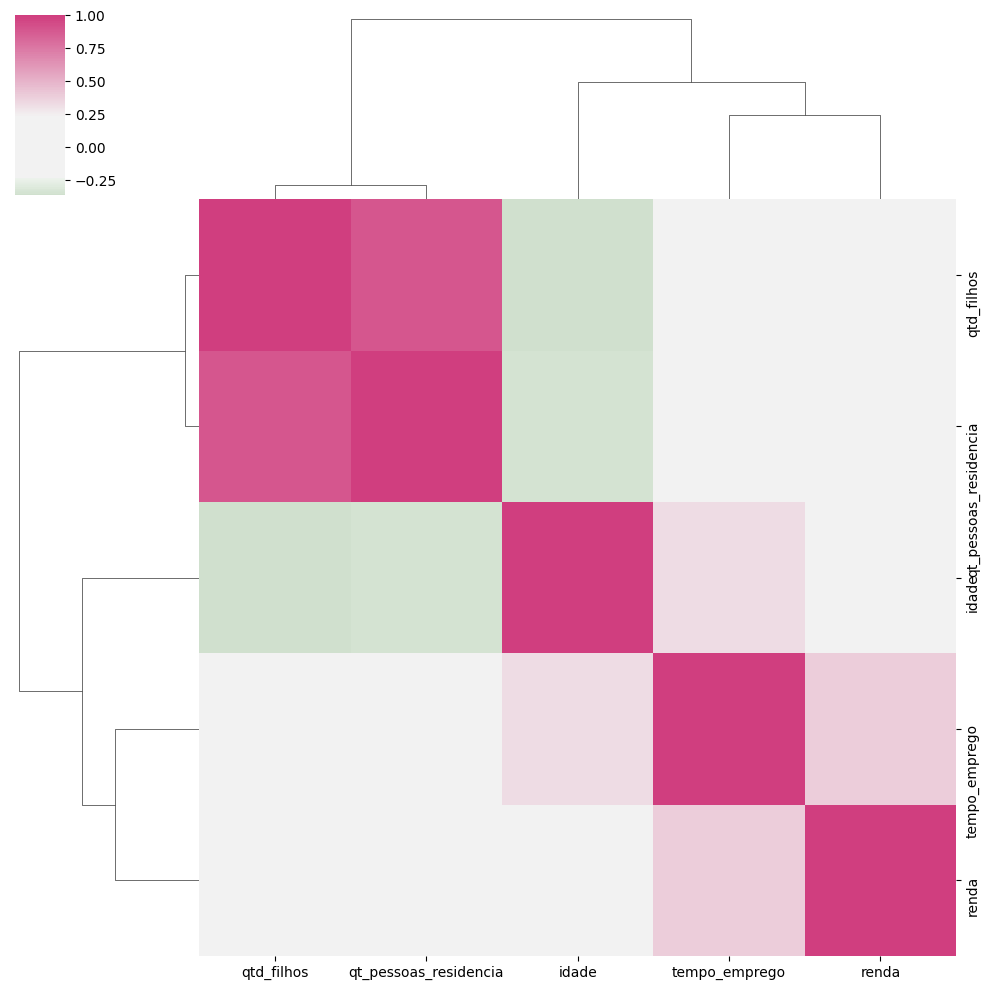

In [ ]:
cmap = sns.diverging_palette(h_neg=125, h_pos=350, as_cmap=True, sep = 60, center = 'light')

sns.clustermap(renda.drop(columns= ['Unnamed: 0', 'id_cliente']).select_dtypes(include='number').corr(), figsize=(10, 10), center = 0, cmap=cmap)

Destaques:

* Quantidade de Filhos x Número de Pessoas Na Residência: 89%
* Tempo de Emprego x Renda: 38%

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



### Limpeza dos Dados

Nessa etapa, iremos retirar as variáveis indesejadas/irrelevantes.

> Retirando as variáveis ```'Unnamed: 0', 'id_cliente'```
 do dataframe.

> Passando a variável `data_ref` para o formato datetime e depois transformando para index.

In [ ]:
renda = renda.assign(data_ref = lambda x : pd.to_datetime(x.data_ref)).set_index('data_ref').drop(columns= ['Unnamed: 0', 'id_cliente'], axis=1)

In [ ]:
renda.dtypes

sexo                      object
posse_de_veiculo            bool
posse_de_imovel             bool
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
dtype: object

### Formatação e Construção

> Analisando os valores missings da variável `tempo_emprego`

In [ ]:
renda[renda.tempo_emprego.isnull()].tipo_renda.value_counts()

tipo_renda
Pensionista    2573
Name: count, dtype: int64

In [ ]:
renda.tipo_renda.value_counts()

tipo_renda
Assalariado         7633
Empresário          3508
Pensionista         2582
Servidor público    1268
Bolsista               9
Name: count, dtype: int64

Podemos perceber que todos os valores missings são de pensionistas. Portanto, iremos transformá-los em 0 pois, esses missings correspondem quase que 100% dos pensionista.

In [ ]:
renda.tempo_emprego.fillna(0, inplace=True)

## Etapa 4 Crisp-DM: Modelagem


### Rodando o modelo


Como a variável de nosso interesse (`renda`) é uma variável numérica, iremos fazer um modelo de regressão, utilizando o método Patsy.

> Utilizando o método `dmatrices`

In [ ]:
renda.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda'],
      dtype='object')

In [ ]:
y, x  = patsy.dmatrices('renda ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia', data=renda)
x

DesignMatrix with shape (15000, 25)
  Columns:
    ['Intercept',
     'sexo[T.M]',
     'posse_de_veiculo[T.True]',
     'posse_de_imovel[T.True]',
     'tipo_renda[T.Bolsista]',
     'tipo_renda[T.Empresário]',
     'tipo_renda[T.Pensionista]',
     'tipo_renda[T.Servidor público]',
     'educacao[T.Pós graduação]',
     'educacao[T.Secundário]',
     'educacao[T.Superior completo]',
     'educacao[T.Superior incompleto]',
     'estado_civil[T.Separado]',
     'estado_civil[T.Solteiro]',
     'estado_civil[T.União]',
     'estado_civil[T.Viúvo]',
     'tipo_residencia[T.Casa]',
     'tipo_residencia[T.Com os pais]',
     'tipo_residencia[T.Comunitário]',
     'tipo_residencia[T.Estúdio]',
     'tipo_residencia[T.Governamental]',
     'qtd_filhos',
     'idade',
     'tempo_emprego',
     'qt_pessoas_residencia']
  Terms:
    'Intercept' (column 0)
    'sexo' (column 1)
    'posse_de_veiculo' (column 2)
    'posse_de_imovel' (column 3)
    'tipo_renda' (columns 4:8)
    'educacao' (col

> Rodando o modelo

In [ ]:
reg_renda = sm.OLS(y, x).fit()

## Etapa 5 Crisp-DM: Avaliação dos resultados


Nessa etapa, iremos avaliar o modelo que treinamos e fazer ajuste com o objetivo de aumentar sua acurácia.

>$R^2$ e Resíduos

O R² é de 0.26219094187248215


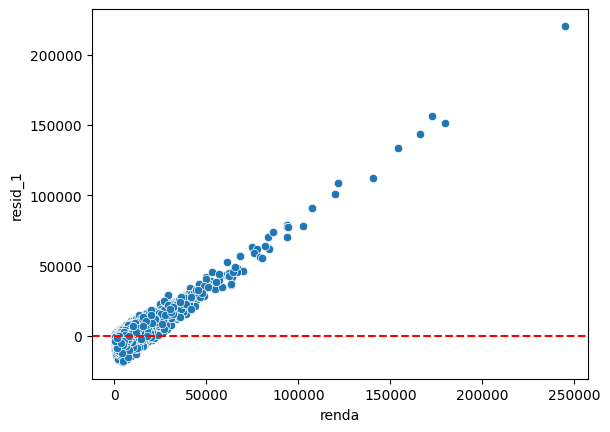

In [ ]:
#Salvando os resíduos
renda['resid_1'] = reg_renda.resid

#Gráfico
sns.scatterplot(x='renda', y='resid_1', data=renda)
plt.axhline(y=0, color='r', linestyle='--')

print(f'O R² é de {reg_renda.rsquared}')

In [ ]:
reg_renda.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     221.7
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:51:00   Log-Likelihood:            -1.5430e+05
No. Observations:               15000   AIC:                         3.087e+05
Df Residuals:                   14975   BIC:                         3.088e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                        -4878.6701   2229.392     -2.188      0.029   -9248.551    -508.789
sexo[T.M]                         5879.7270    137.106     42.885      0.000    5610.982    6148.472
posse_de_veiculo[T.True]             6.2182    129.843      0.048      0.962    -248.291     260.727
posse_de_imovel[T.True]            387.4028    127.962      3.027      0.002     136.581     638.224
tipo_renda[T.Bolsista]           -1433.4495   2374.406     -0.604      0.546   -6087.576    3220.677
tipo_renda[T.Empresário]           810.8514    146.884      5.520      0.000     522.940    1098.763
tipo_renda[T.Pensionista]         2690.2177    236.476     11.376      0.000    2226.697    3153.739
tipo_renda[T.Servidor público]     124.9884    218.593      0.572      0.567    -303.480     553.457
educacao[T.Pós graduação]          625.2472   1504.206      0.416      0.678   -2323.181    3573.676
educacao[T.Secundário]             154.1790    560.479      0.275      0.783    -944.429    1252.787
educacao[T.Superior completo]      783.0261    564.938      1.386      0.166    -324.321    1890.373
educacao[T.Superior incompleto]   -218.7200    631.907     -0.346      0.729   -1457.334    1019.894
estado_civil[T.Separado]           982.7116   1067.829      0.920      0.357   -1110.363    3075.787
estado_civil[T.Solteiro]           733.9742   1047.273      0.701      0.483   -1318.809    2786.757
estado_civil[T.União]             -493.0130    228.952     -2.153      0.031    -941.787     -44.239
estado_civil[T.Viúvo]              983.5765   1077.717      0.913      0.361   -1128.881    3096.034
tipo_residencia[T.Casa]           -213.1983    517.574     -0.412      0.680   -1227.707     801.311
tipo_residencia[T.Com os pais]    -288.5781    580.819     -0.497      0.619   -1427.055     849.899
tipo_residencia[T.Comunitário]    -421.3319   1029.140     -0.409      0.682   -2438.573    1595.909
tipo_residencia[T.Estúdio]         186.2067    935.434      0.199      0.842   -1647.359    2019.773
tipo_residencia[T.Governamental]   360.9207    614.680      0.587      0.557    -843.928    1565.769
qtd_filhos                       -1016.5059   1040.217     -0.977      0.328   -3055.458    1022.446
idade                               40.6791      7.559      5.381      0.000      25.862      55.497
tempo_emprego                      552.7427     10.172     54.338      0.000     532.804     572.681
qt_pessoas_residencia             1146.5441   1038.281      1.104      0.269    -888.613    3181.701
==============================================================================
Omnibus:                    21863.118   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15345272.223
Skew:             

Os resíduos estão muito concentrados, sinal que podemos melhorar.

Iremos rodar outro modelo com as variáveis mais significantes baseado na análise do p-value, e iremos utilizar a função log na variável `renda`, por se tratar de uma variável monetária. E iremos categorizar as variáveis `tempo_emprego`, `qtd_filhos` e `idade`.

In [ ]:
y, x = patsy.dmatrices('np.log(renda) ~ sexo + C(tempo_emprego) + C(qtd_filhos) + C(idade)',renda)
reg_renda = sm.OLS(y, x)
reg_renda = reg_renda.fit()
reg_renda.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     5.917
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:09:35   Log-Likelihood:                -13290.
No. Observations:               15000   AIC:                         3.187e+04
Df Residuals:                   12356   BIC:                         5.200e+04
Df Model:                        2643                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  7.8216      0.255     30.720      0.000       7.323       8.321
sexo[T.M]                                  0.7769      0.019     40.999      0.000       0.740       0.814
C(tempo_emprego)[T.0.1178082191780822]    -0.9401      0.462     -2.035      0.042      -1.846      -0.035
C(tempo_emprego)[T.0.1780821917808219]     0.0173      0.379      0.046      0.964      -0.726       0.761
C(tempo_emprego)[T.0.2]                   -0.1523      0.327     -0.466      0.641      -0.792       0.488
C(tempo_emprego)[T.0.2164383561643836]     0.8959      0.650      1.379      0.168      -0.378       2.170
C(tempo_emprego)[T.0.2410958904109589]     0.2990      0.650      0.460      0.646      -0.975       1.573
C(tempo_emprego)[T.0.2438356164383561]    -0.2819      0.460     -0.613      0.540      -1.183       0.620
C(tempo_emprego)[T.0.2493150684931507]     0.2197      0.379      0.580      0.562      -0.523       0.962
C(tempo_emprego)[T.0.252054794520548]     -1.2748      0.650     -1.961      0.050      -2.549      -0.001
C(tempo_emprego)[T.0.2547945205479452]     0.1825      0.210      0.869      0.385      -0.229       0.594
C(tempo_emprego)[T.0.2602739726027397]    -0.6556      0.249     -2.635      0.008      -1.143      -0.168
C(tempo_emprego)[T.0.2630136986301369]     0.1816      0.220      0.825      0.410      -0.250       0.613
C(tempo_emprego)[T.0.2657534246575343]    -0.6266      0.268     -2.338      0.019      -1.152      -0.101
C(tempo_emprego)[T.0.2712328767123288]     0.1266      0.379      0.334      0.739      -0.617       0.870
C(tempo_emprego)[T.0.2767123287671233]    -0.7190      0.249     -2.883      0.004      -1.208      -0.230
C(tempo_emprego)[T.0.2794520547945205]    -0.5585      0.219     -2.553      0.011      -0.987      -0.130
C(tempo_emprego)[T.0.2821917808219178]     0.6683      0.650      1.029      0.304      -0.605       1.942
C(tempo_emprego)[T.0.284931506849315]     -0.1703      0.330     -0.516      0.606      -0.816       0.476
C(tempo_emprego)[T.0.2876712328767123]    -0.4874      0.379     -1.287      0.198      -1.230       0.255
C(tempo_emprego)[T.0.2931506849315069]    -0.6670      0.460     -1.450      0.147      -1.569       0.235
C(tempo_emprego)[T.0.2958904109589041]    -0.3839      0.190     -2.017      0.044      -0.757      -0.011
C(tempo_emprego)[T.0.2986301369863013]    -0.3302      0.295     -1.120      0.263      -0.908       0.248
C(tempo_emprego)[T.0.3013698630136986]    -0.2517      0.270     -0.933      0.351      -0.780       0.277
C(tempo_emprego)[T.0.3205479452054795]    -0.4504      0.327     -1.376      0.169      -1.092       0.191
C(tempo_emprego)[T.0.3232876712328767]    -0.4554      0.462     -0.986      0.324     

O R² é de 0.6661086088056339


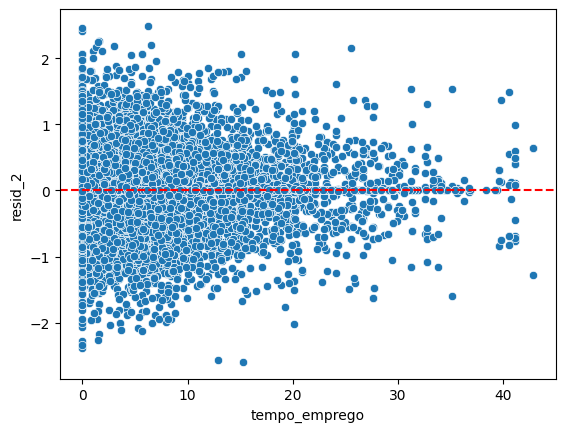

In [ ]:
#Gráfico de Resíduo
renda['resid_2'] = reg_renda.resid
sns.scatterplot(x='tempo_emprego', y='resid_2', data=renda)
plt.axhline(y=0, color='r', linestyle='--')

#R²
renda['pred_renda'] = np.exp(reg_renda.predict())
R2 = renda['pred_renda'].corr(renda['renda'])**2
print(f'O R² é de {R2}')

Com isso, teremos um resíduo bem mais disperso do que antes, e com um $R^2$ mais do que 2x maior do que o primeiro modelo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.